In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
import statsmodels.api as sm
import statsmodels.formula.api as smf
players1 = pd.read_csv("phs_2020_1.csv")
players2 = pd.read_csv("phs_2020_2.csv")
combine = [players1, players2]
data = pd.concat(combine).drop(['start_time'], axis=1)
data.drop(data.index[data['tournament_title'] != 'OWL 2020 Regular Season'], inplace=True)
data.drop(['tournament_title'], axis = 1, inplace = True)
cols = ['esports_match_id', 'map_type', 'map_name', 'player_name', 'team_name', 'hero_name', 'stat_name', 'stat_amount']
data = data.reindex(columns = cols)
data = data[data["hero_name"] != "All Heroes"]
stats = ['Hero Damage Done', 'Assists', 'Barrier Damage Done', 'Deaths', 'Eliminations', 'Objective Kills', 'Objective Time', 'Ultimates Earned - Fractional', 'Final Blows', 'Damage Blocked', 'Healing Done']
data = data.loc[data['stat_name'].isin(stats)]
data['stat_amount'] = data['stat_amount'].round(decimals = 2)

# Tidy dataset to elongate stat_name column into rows and insert respective stat_amount values
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']].copy().reset_index()
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']]
data = data.pivot_table(values='stat_amount', index=[data['esports_match_id'],data['team_name'], data['player_name'], data['map_name'], data['hero_name']], columns='stat_name', aggfunc='sum')
data = data.fillna(0)
data = data.reset_index()
data.rename(columns = {'Ultimates Earned - Fractional':'Ultimates Earned'}, inplace = True)
print(data['esports_match_id'].max())
print(data['esports_match_id'].min())
data['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
data

35554
30991


stat_name,esports_match_id,team_name,player_name,map_name,hero_name,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24946,35554,Seoul Dynasty,Profit,Temple of Anubis,Pharah,0.0,0.00,0.00,1.0,1.0,1.0,0.00,883.85,0.0,0.00,0.63
24947,35554,Seoul Dynasty,tobi,Busan,Mercy,1.0,30.00,0.00,2.0,3.0,2.0,6772.00,200.00,0.0,8.23,3.85
24948,35554,Seoul Dynasty,tobi,Kings Row,Mercy,1.0,20.00,0.00,1.0,2.0,1.0,9917.83,407.64,1.0,41.80,5.33
24949,35554,Seoul Dynasty,tobi,Temple of Anubis,Lúcio,1.0,20.00,0.00,0.0,2.0,1.0,295.03,552.82,1.0,18.45,0.35


In [33]:
maps = pd.read_csv("match_map_stats.csv")
maps['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
maps['map_name'].unique()

array(['Dorado', 'Temple of Anubis', 'Ilios', 'Numbani', 'Eichenwalde',
       'Junkertown', 'Oasis', 'Horizon Lunar Colony', 'Lijiang Tower',
       'Volskaya Industries', 'Nepal', 'Kings Row', 'Route 66',
       'Hollywood', 'Hanamura', 'Watchpoint: Gibraltar', 'Blizzard World',
       'Rialto', 'Busan', 'Paris', 'Havana'], dtype=object)

In [34]:
cleaned_maps = pd.DataFrame()
maps.query("`match_id` >= 30991", inplace = True)
maps.query("`match_id` <= 36231", inplace = True)
cleaned_maps = pd.DataFrame(maps, columns = ['match_id', 'team_one_name', 'team_two_name', 'map_winner', 'map_name', 'game_number', 'match_winner'])
cleaned_maps.rename(columns = {'team_one_name': 'team_one', 'team_two_name': 'team_two'}, inplace = True)
cleaned_maps.drop_duplicates(inplace = True)
cleaned_maps.head()

,match_id,team_one,team_two,map_winner,map_name,game_number,match_winner
6246,30991,Toronto Defiant,Paris Eternal,Paris Eternal,Lijiang Tower,1,Toronto Defiant
6248,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Eichenwalde,2,Toronto Defiant
6252,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Horizon Lunar Colony,3,Toronto Defiant
6255,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Havana,4,Toronto Defiant
6257,30992,London Spitfire,New York Excelsior,London Spitfire,Lijiang Tower,1,New York Excelsior


We can see that there are not many visibile errors except team_one and team_two switches their 

In [35]:
new_frame = pd.DataFrame(columns = cleaned_maps.columns)
for index, row in cleaned_maps.iterrows():
    if row['team_two'] < row['team_one']:
        new_frame.loc[index] = [row['match_id'], row['team_two'], row['team_one'], row['map_winner'], row['map_name'], row['game_number'], row['match_winner']]
    else:
        new_frame.loc[index] = [row['match_id'], row['team_one'], row['team_two'], row['map_winner'], row['map_name'], row['game_number'], row['match_winner']]
cleaned_maps = new_frame
cleaned_maps.head()      

,match_id,team_one,team_two,map_winner,map_name,game_number,match_winner
6246,30991,Paris Eternal,Toronto Defiant,Paris Eternal,Lijiang Tower,1,Toronto Defiant
6248,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Eichenwalde,2,Toronto Defiant
6252,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Horizon Lunar Colony,3,Toronto Defiant
6255,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Havana,4,Toronto Defiant
6257,30992,London Spitfire,New York Excelsior,London Spitfire,Lijiang Tower,1,New York Excelsior


In [36]:
win_perc = pd.DataFrame(columns = ['map_name', 'team', 'wins', 'games_played'])
played_dict = dict.fromkeys(cleaned_maps['team_one'].unique(), 0)
win_dict = dict.fromkeys(cleaned_maps['team_one'].unique(), 0)

for name in cleaned_maps['map_name'].unique():
    temp_pd = pd.DataFrame()
    team = cleaned_maps.query("`map_name` == '{}'".format(name))
    for index, row in team.iterrows():
        if (row['map_winner'] != 'draw'):
            played_dict[row['team_one']] = played_dict.get(row['team_one'],0) + 1
            played_dict[row['team_two']] = played_dict.get(row['team_two'],0) + 1
            if (row['team_one'] == row['map_winner']):
                win_dict[row['team_one']] = win_dict.get(row['team_one'],0) + 1
            else:
                win_dict[row['team_two']] = win_dict.get(row['team_one'],0) + 1
    for team_name in cleaned_maps['team_one'].unique():
        temp_dict = {'map_name': name, 'team': team_name, 'wins': win_dict.get(team_name, 0), 'games_played': played_dict.get(team_name, 0)}
        win_perc = win_perc.append(temp_dict, ignore_index = True)
    played_dict = dict.fromkeys(cleaned_maps['team_one'].unique(), 0)
    win_dict = dict.fromkeys(cleaned_maps['team_one'].unique(), 0)
win_perc

,map_name,team,wins,games_played
0,Lijiang Tower,Paris Eternal,6,10
1,Lijiang Tower,London Spitfire,1,6
2,Lijiang Tower,Los Angeles Gladiators,5,13
3,Lijiang Tower,Dallas Fuel,3,7
4,Lijiang Tower,Boston Uprising,3,9
...,...,...,...,...
373,Watchpoint: Gibraltar,Toronto Defiant,1,3
374,Watchpoint: Gibraltar,Hangzhou Spark,5,5
375,Watchpoint: Gibraltar,Seoul Dynasty,5,8
376,Watchpoint: Gibraltar,Vancouver Titans,2,5


In [37]:
win_perc['games_played'].replace({0: np.nan}, inplace = True)
win_perc['win_perc'] = win_perc['wins'] / win_perc['games_played']
win_perc

,map_name,team,wins,games_played,win_perc
0,Lijiang Tower,Paris Eternal,6,10.0,0.6
1,Lijiang Tower,London Spitfire,1,6.0,0.166667
2,Lijiang Tower,Los Angeles Gladiators,5,13.0,0.384615
3,Lijiang Tower,Dallas Fuel,3,7.0,0.428571
4,Lijiang Tower,Boston Uprising,3,9.0,0.333333
...,...,...,...,...,...
373,Watchpoint: Gibraltar,Toronto Defiant,1,3.0,0.333333
374,Watchpoint: Gibraltar,Hangzhou Spark,5,5.0,1.0
375,Watchpoint: Gibraltar,Seoul Dynasty,5,8.0,0.625
376,Watchpoint: Gibraltar,Vancouver Titans,2,5.0,0.4


In [38]:
data

stat_name,esports_match_id,team_name,player_name,map_name,hero_name,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24946,35554,Seoul Dynasty,Profit,Temple of Anubis,Pharah,0.0,0.00,0.00,1.0,1.0,1.0,0.00,883.85,0.0,0.00,0.63
24947,35554,Seoul Dynasty,tobi,Busan,Mercy,1.0,30.00,0.00,2.0,3.0,2.0,6772.00,200.00,0.0,8.23,3.85
24948,35554,Seoul Dynasty,tobi,Kings Row,Mercy,1.0,20.00,0.00,1.0,2.0,1.0,9917.83,407.64,1.0,41.80,5.33
24949,35554,Seoul Dynasty,tobi,Temple of Anubis,Lúcio,1.0,20.00,0.00,0.0,2.0,1.0,295.03,552.82,1.0,18.45,0.35


In [39]:
map_list = data['map_name'].unique()
hero_list = data['hero_name'].unique()
pick_rate = {}
for name in map_list:
    # Initialized dictionary of map pick rate per 
    map_rate = {}
    for val in hero_list:
        map_rate[val] = 0
    for index, row in data.iterrows():
        #row[3] is map, and row[4] is hero
        if row[3] == name:
            map_rate[row[4]] = map_rate[row[4]] + 1
    pick_rate[name] = map_rate
pick_frame = pd.DataFrame()

for name_map in map_list:
    for name_hero in hero_list:
        temp_dict = {'map_name': name_map, 'hero_name': name_hero, 'pick': pick_rate.get(name_map, 0).get(name_hero, 0)}
        pick_frame = pick_frame.append(temp_dict, ignore_index = True)
pick_frame
        

,map_name,hero_name,pick
0,Eichenwalde,Reinhardt,34.0
1,Eichenwalde,Lúcio,59.0
2,Eichenwalde,Baptiste,54.0
3,Eichenwalde,Moira,35.0
4,Eichenwalde,Ana,45.0
...,...,...,...
667,Watchpoint: Gibraltar,Soldier: 76,14.0
668,Watchpoint: Gibraltar,Junkrat,0.0
669,Watchpoint: Gibraltar,Torbjörn,9.0
670,Watchpoint: Gibraltar,Ashe,37.0


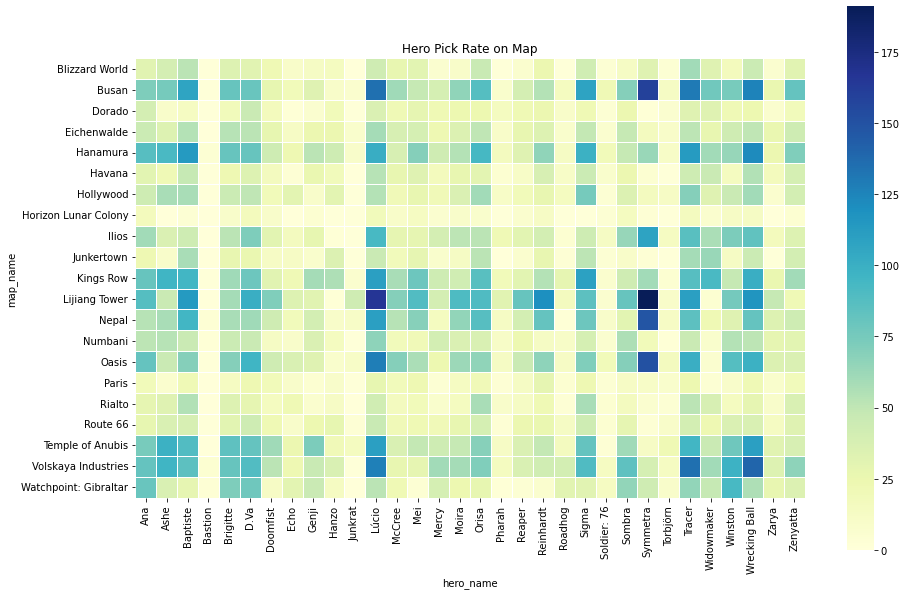

In [40]:
new_data = pick_frame.pivot(index='map_name', columns='hero_name', values='pick')
figure, axis = plt.subplots(figsize=(15,10))
plt.title('Hero Pick Rate on Map')
sns.heatmap(new_data,cmap = "YlGnBu", ax=axis, square=True, linewidths=.6)
plt.show()

In [41]:
merged_df = pd.merge(data, cleaned_maps, how = 'left', left_on = ['esports_match_id', 'map_name'], right_on = ['match_id', 'map_name'])
def win_calc (row):
    # 1 represents the team in that row won the map
    if (row['team_name'] == row['map_winner']):
        return 1
    return 0
merged_df['winner'] = merged_df.apply(lambda row: win_calc(row), axis=1)
merged_df.drop(['team_one', 'team_two', 'game_number', 'match_winner', 'match_id', 'map_winner'], axis = 1, inplace = True)
merged_df.head()

,esports_match_id,team_name,player_name,map_name,hero_name,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned,winner
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97,0
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15,0
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52,0
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71,1
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03,0


In [49]:
damagers = ['Ashe', 'Bastion', 'McCree', 'Echo', 'Genji', 'Hanzo', 'Junkrat', 'Mei', 'Pharah', 'Reaper', 'Soldier: 76', 'Sombra', 'Symmetra'
           'Torbjörn', 'Tracer', 'Widowmaker']
tanks = ['D.Va', 'Doomfist', 'Orisa', 'Reinhardt', 'Roadhog', 'Sigma', 'Winston', 'Wrecking Ball', 'Zarya']
supports = ['Ana', 'Baptiste', 'Brigitte', 'Lúcio', 'Mercy', 'Moira', 'Zenyatta']
classes = ['Damage', 'Support', 'Tank']
res_array = []
for curr_class in classes:
    # Take rows of only heroes of the current class
    if (curr_class == 'Damage'):
        curr_table = merged_df.loc[merged_df['hero_name'].isin(damagers)].copy()
        curr_table.columns = curr_table.columns.str.replace(' ','_')
        formula_class = 'winner ~ Assists + Barrier_Damage_Done + Deaths + Eliminations + Final_Blows + Hero_Damage_Done + Ultimates_Earned'
    elif (curr_class == 'Support'):
        curr_table = merged_df.loc[merged_df['hero_name'].isin(supports)].copy()
        curr_table.columns = curr_table.columns.str.replace(' ','_')
        formula_class = 'winner ~ Assists + Deaths + Eliminations + Hero_Damage_Done + Ultimates_Earned + Healing_Done'
    else:
        curr_table = merged_df.loc[merged_df['hero_name'].isin(tanks)].copy()
        curr_table.columns = curr_table.columns.str.replace(' ','_')
        formula_class = 'winner ~ Assists + Deaths + Eliminations + Hero_Damage_Done + Ultimates_Earned + Barrier_Damage_Done + Damage_Blocked'
    mod = smf.ols(formula = formula_class, data = curr_table)
    res = mod.fit()
    res_array.append(res)

In [54]:
# Damage regression fit
print(res_array[0].summary())

                            OLS Regression Results                            
Dep. Variable:                 winner   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     346.8
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        12:14:29   Log-Likelihood:                -4843.6
No. Observations:                8163   AIC:                             9703.
Df Residuals:                    8155   BIC:                             9759.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4569    

In [55]:
# Support regression fit
print(res_array[1].summary())

                            OLS Regression Results                            
Dep. Variable:                 winner   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     389.0
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        12:14:41   Log-Likelihood:                -4245.7
No. Observations:                7263   AIC:                             8505.
Df Residuals:                    7256   BIC:                             8554.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4685      0.009  

In [56]:
# Tank regression fit
print(res_array[2].summary())

                            OLS Regression Results                            
Dep. Variable:                 winner   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     446.6
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        12:15:36   Log-Likelihood:                -4630.8
No. Observations:                8250   AIC:                             9278.
Df Residuals:                    8242   BIC:                             9334.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4389    